# 作业3：深度学习框架实践

本次作业将练习深度学习框架的使用，大部分内容用 PyTorch 实现。第1题利用卷积层和全连接层实现手写数字的识别，第2题利用 RNN 来实现英文名的自动生成，第3题是算法题，利用卷积运算实现任意大整数的乘法。

### 第1题

1. 目标：通过对 MNIST 数据进行训练，构建一个简单的图像分类模型，对图片中的数字进行识别。你将利用该模型对自己真实手写出的数字进行预测，观察模型效果。

2. 主要步骤：获取数据，创建模型结构，定义损失函数，编写训练循环，实施预测。

3. 获取数据。我们使用知名的 MNIST 数据集，它可以从 PyTorch 中利用工具函数下载得到。原始的 MNIST 数据训练集大小为60000，我们随机抽取其中的10000个观测进行简单的训练。以下函数会在当前目录建立一个名为 data 的文件夹，其中会包含下载得到的数据集。

**注意：请在任何程序的最开始加上随机数种子的设置。请保持这一习惯。**

In [1]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

np.random.seed(123)
torch.manual_seed(123)

In [2]:
mnist = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
loader = DataLoader(mnist, batch_size=10000, shuffle=True)

我们一次性取出随机抽取到的10000个观测，其中 x 是图片数据，y 是图片对应的数字。

In [3]:
x, y = next(iter(loader))

一个习惯性动作是查看数据的大小和维度。

In [4]:
print(x.shape)
print(y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


我们可以利用下面的函数展示图片的内容。如选择第一张图片，先将其转换成 Numpy 数组，再绘制图形：

(28, 28)


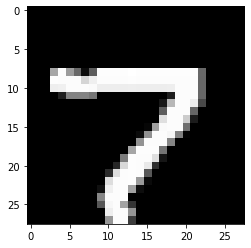

In [5]:
import matplotlib.pyplot as plt

img = x[0].squeeze().cpu().numpy()
print(img.shape)
plt.imshow(img, cmap="gray")
plt.show()

接下来请你选择5个你喜欢的数字（10000以下），然后取出对应位置的图片，并画出它们的内容。

(28, 28)


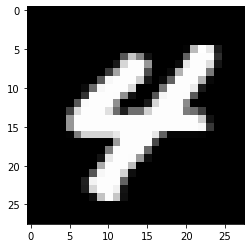

(28, 28)


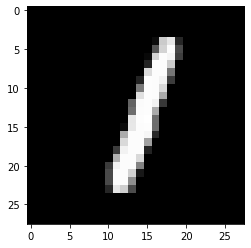

(28, 28)


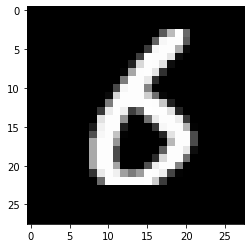

(28, 28)


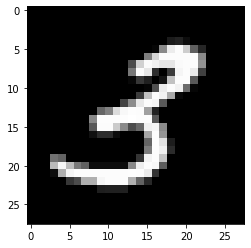

(28, 28)


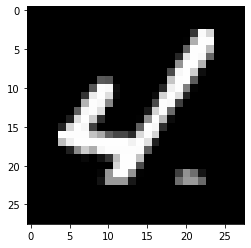

In [6]:
for num in [111,222,333,444,555]:
    img = x[num].squeeze().cpu().numpy()
    print(img.shape)
    plt.imshow(img, cmap="gray")
    plt.show()

4. 搭建模型。我们搭建一个类似于 LeNet-5 的网络，结构如下：

![](https://pic1.zhimg.com/80/v2-82eabb4c17e90d467197d013f7629f3c_720w.jpg)

我们需要创建2个卷积层、2个汇聚层（池化层）和2个全连接层，**暂时忽略所有的激活函数**。所有隐藏层的函数细节都可以在[官方文档](https://pytorch.org/docs/stable/nn.html)中按分类找到。每一个隐藏层本质上都是将一个数组变换成另一个数组的函数，因此为了确认编写的模型是正确的，可以先用一个小数据进行测试，观察输入和输出的维度。例如，我们先取出前10个观测，此时输入的维度是 `[10, 1, 28, 28]`：

In [9]:
smallx = x[0:10]
smally = y[0:10]
print(smallx.shape)
print(smally.shape)

torch.Size([10, 1, 28, 28])
torch.Size([10])


接下来创建第1个卷积层，并测试输出的维度。注意到我们可以直接将隐藏层当成一个函数来调用。

In [8]:
conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
res = conv1(smallx)
print(res.shape)

torch.Size([10, 20, 24, 24])


可以看到，输出的维度为 `[20, 24, 24]`（不包括第1位的数据批次维度），与之前图中的结果吻合。

接下来，请按照图中提示编写层对象 `pool1`、`conv2`、`pool2`、`fc1` 和 `fc2`，并顺次测试输入与输出的维度，使其与上图匹配。注意，在将一个大小为 `[10, 50, 4, 4]` 的数组（假设叫 `somearray`）传递给 `fc1` 之前，需要先将其变形为只有两个维度的数组，做法是 `somearray.view(-1, 50*4*4)`，其中 -1 表示该位置的大小不变。

In [9]:
pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool1(res)
print(res.shape)

conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
res = conv2(res)
print(res.shape)

pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
res = pool2(res)
print(res.shape)

fc1 = torch.nn.Linear(50 * 4 * 4, 500)
res = fc1(res.view(-1, 50 * 4 * 4))
print(res.shape)

relu = torch.nn.ReLU()
res = relu(res)
print(res.shape)

fc2 = torch.nn.Linear(500, 10)
res = fc2(res)
print(res.shape)

softmax = torch.nn.Softmax(dim=1)
res = softmax(res)
print(res.shape)

torch.Size([10, 20, 12, 12])
torch.Size([10, 50, 8, 8])
torch.Size([10, 50, 4, 4])
torch.Size([10, 500])
torch.Size([10, 500])
torch.Size([10, 10])
torch.Size([10, 10])


5. 创建模型类。在确保隐藏层维度都正确后，将所有的隐藏层封装到一个模型类中，其中模型结构在 `__init__()` 中定义，具体的计算过程在 `forward()` 中实现。此时需要加入激活函数。在本模型中，**请在 `conv1`、`conv2` 和 `fc1` 后加入 ReLU 激活函数，并在 `fc2` 后加入 Softmax 激活函数**。

In [6]:
class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(50 * 4 * 4, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.fc1(x.view(-1, 50 * 4 * 4))
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.softmax(x, dim=1)
        return x

再次测试输入输出的维度是否正确。如果模型编写正确，输出的维度应该是 `[10, 10]`，且输出结果为0到1之间的概率值。

In [12]:
np.random.seed(123)
torch.manual_seed(123)

model = MyModel()
pred = model(smallx)
print(pred.shape)
print(pred)
print(smally)

torch.Size([10, 10])
tensor([[0.0992, 0.0989, 0.0982, 0.1089, 0.0943, 0.0912, 0.0996, 0.1020, 0.1021,
         0.1056],
        [0.0997, 0.1004, 0.0978, 0.1085, 0.0938, 0.0907, 0.0982, 0.1045, 0.1020,
         0.1045],
        [0.0990, 0.0993, 0.0979, 0.1081, 0.0913, 0.0921, 0.0976, 0.1088, 0.1030,
         0.1031],
        [0.0955, 0.0996, 0.1010, 0.1081, 0.0931, 0.0913, 0.0988, 0.1044, 0.1031,
         0.1051],
        [0.0995, 0.0988, 0.0985, 0.1091, 0.0919, 0.0918, 0.0980, 0.1059, 0.1017,
         0.1049],
        [0.0977, 0.0994, 0.0996, 0.1073, 0.0924, 0.0922, 0.1018, 0.1019, 0.1040,
         0.1038],
        [0.0972, 0.1011, 0.1010, 0.1062, 0.0931, 0.0908, 0.1006, 0.1048, 0.1037,
         0.1016],
        [0.0996, 0.0984, 0.0987, 0.1068, 0.0904, 0.0900, 0.0992, 0.1076, 0.1020,
         0.1075],
        [0.0972, 0.0998, 0.1012, 0.1084, 0.0925, 0.0905, 0.1022, 0.1014, 0.1023,
         0.1045],
        [0.0979, 0.0998, 0.0985, 0.1080, 0.0959, 0.0910, 0.0979, 0.1049, 0.1027,
       

`pred` 的每一行加总为1，其中每一个元素代表对应类别的预测概率。

我们还可以直接打印模型对象，观察隐藏层的结构：

In [13]:
print(model)

MyModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


6. 损失函数。对于分类问题，损失函数通常选取为负对数似然函数。在 PyTorch 中，可以使用 `torch.nn.NLLLoss` 来完成计算。其用法是先定义一个损失函数对象，然后在预测值和真实标签上调用该函数对象。注意：损失函数对象的第一个参数是预测概率的**对数值**，第二个参数是真实的标签。[文档说明](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)。

In [14]:
lossfn = torch.nn.NLLLoss()
lossfn(torch.log(pred), smally)

tensor(2.3231, grad_fn=<NllLossBackward>)

7. 利用课上介绍的循环模板和代码示例，对模型进行迭代训练。对于本数据，选取 mini-batch 大小为200，共遍历数据10遍，优化器选为 Adam，学习率为0.001。

In [7]:
BATCH_SIZE = 200
EPOCH      = 10
LR         = 0.001

model  = MyModel()
loader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True)
opt    = torch.optim.Adam(model.parameters(), lr=0.001)
lossfn = torch.nn.NLLLoss()
for i in range(EPOCH):
    j = 0
    for x, y in loader:
        pred = model(x)
        loss = lossfn(torch.log(pred), y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        j += 1
        if (j // BATCH_SIZE) % 10 == 0:
            print(f"epoch {i+1}, batch {j+1}, loss = {loss.item()}")

epoch 1, batch 2, loss = 2.3050460815429688
epoch 1, batch 3, loss = 2.2473204135894775
epoch 1, batch 4, loss = 2.2203662395477295
epoch 1, batch 5, loss = 2.166632890701294
epoch 1, batch 6, loss = 2.0988450050354004
epoch 1, batch 7, loss = 2.04423451423645
epoch 1, batch 8, loss = 1.8825541734695435
epoch 1, batch 9, loss = 1.7789987325668335
epoch 1, batch 10, loss = 1.7005940675735474
epoch 1, batch 11, loss = 1.4537014961242676
epoch 1, batch 12, loss = 1.315425992012024
epoch 1, batch 13, loss = 1.2458666563034058
epoch 1, batch 14, loss = 1.1077849864959717
epoch 1, batch 15, loss = 1.007583498954773
epoch 1, batch 16, loss = 0.8979427218437195
epoch 1, batch 17, loss = 0.7679138779640198
epoch 1, batch 18, loss = 0.7869899272918701
epoch 1, batch 19, loss = 0.7071364521980286
epoch 1, batch 20, loss = 0.6270896792411804
epoch 1, batch 21, loss = 0.6990595459938049
epoch 1, batch 22, loss = 0.6995390057563782
epoch 1, batch 23, loss = 0.6035932898521423
epoch 1, batch 24, loss

epoch 1, batch 182, loss = 0.14431951940059662
epoch 1, batch 183, loss = 0.07141241431236267
epoch 1, batch 184, loss = 0.16411590576171875
epoch 1, batch 185, loss = 0.0713929682970047
epoch 1, batch 186, loss = 0.11358346790075302
epoch 1, batch 187, loss = 0.17957812547683716
epoch 1, batch 188, loss = 0.11624517291784286
epoch 1, batch 189, loss = 0.0713072195649147
epoch 1, batch 190, loss = 0.1054958701133728
epoch 1, batch 191, loss = 0.07586383819580078
epoch 1, batch 192, loss = 0.07723506540060043
epoch 1, batch 193, loss = 0.08352962136268616
epoch 1, batch 194, loss = 0.04781626537442207
epoch 1, batch 195, loss = 0.09956946223974228
epoch 1, batch 196, loss = 0.13867880403995514
epoch 1, batch 197, loss = 0.1403398960828781
epoch 1, batch 198, loss = 0.11380694061517715
epoch 1, batch 199, loss = 0.1302448809146881
epoch 1, batch 200, loss = 0.07064805924892426
epoch 2, batch 2, loss = 0.08442145586013794
epoch 2, batch 3, loss = 0.0304433424025774
epoch 2, batch 4, loss 

epoch 2, batch 161, loss = 0.04972610995173454
epoch 2, batch 162, loss = 0.07994469255208969
epoch 2, batch 163, loss = 0.10722971707582474
epoch 2, batch 164, loss = 0.0961739644408226
epoch 2, batch 165, loss = 0.037535469979047775
epoch 2, batch 166, loss = 0.07717525213956833
epoch 2, batch 167, loss = 0.02252839133143425
epoch 2, batch 168, loss = 0.03943777084350586
epoch 2, batch 169, loss = 0.07181132584810257
epoch 2, batch 170, loss = 0.04885997623205185
epoch 2, batch 171, loss = 0.044203244149684906
epoch 2, batch 172, loss = 0.03710553050041199
epoch 2, batch 173, loss = 0.16433531045913696
epoch 2, batch 174, loss = 0.042727041989564896
epoch 2, batch 175, loss = 0.08356107771396637
epoch 2, batch 176, loss = 0.05505504459142685
epoch 2, batch 177, loss = 0.05331771820783615
epoch 2, batch 178, loss = 0.029325848445296288
epoch 2, batch 179, loss = 0.039843589067459106
epoch 2, batch 180, loss = 0.05274667590856552
epoch 2, batch 181, loss = 0.059539083391427994
epoch 2,

epoch 3, batch 138, loss = 0.04299290105700493
epoch 3, batch 139, loss = 0.05976196378469467
epoch 3, batch 140, loss = 0.03685297816991806
epoch 3, batch 141, loss = 0.028913049027323723
epoch 3, batch 142, loss = 0.020775064826011658
epoch 3, batch 143, loss = 0.045138705521821976
epoch 3, batch 144, loss = 0.04534835368394852
epoch 3, batch 145, loss = 0.024429945275187492
epoch 3, batch 146, loss = 0.018607869744300842
epoch 3, batch 147, loss = 0.01885182596743107
epoch 3, batch 148, loss = 0.023571422323584557
epoch 3, batch 149, loss = 0.03673050180077553
epoch 3, batch 150, loss = 0.03155186027288437
epoch 3, batch 151, loss = 0.040457554161548615
epoch 3, batch 152, loss = 0.05911850556731224
epoch 3, batch 153, loss = 0.010503483936190605
epoch 3, batch 154, loss = 0.03692091628909111
epoch 3, batch 155, loss = 0.04629363492131233
epoch 3, batch 156, loss = 0.055661436170339584
epoch 3, batch 157, loss = 0.01036430150270462
epoch 3, batch 158, loss = 0.07032711803913116
epoc

epoch 4, batch 114, loss = 0.023956023156642914
epoch 4, batch 115, loss = 0.018056683242321014
epoch 4, batch 116, loss = 0.02671082504093647
epoch 4, batch 117, loss = 0.012370525859296322
epoch 4, batch 118, loss = 0.03244800493121147
epoch 4, batch 119, loss = 0.023915447294712067
epoch 4, batch 120, loss = 0.042474281042814255
epoch 4, batch 121, loss = 0.04853648692369461
epoch 4, batch 122, loss = 0.014810805208981037
epoch 4, batch 123, loss = 0.030283043161034584
epoch 4, batch 124, loss = 0.02412671037018299
epoch 4, batch 125, loss = 0.05062371864914894
epoch 4, batch 126, loss = 0.007174113765358925
epoch 4, batch 127, loss = 0.06499283015727997
epoch 4, batch 128, loss = 0.025952525436878204
epoch 4, batch 129, loss = 0.05460438132286072
epoch 4, batch 130, loss = 0.0585109107196331
epoch 4, batch 131, loss = 0.029693912714719772
epoch 4, batch 132, loss = 0.02048627845942974
epoch 4, batch 133, loss = 0.03957844153046608
epoch 4, batch 134, loss = 0.016599297523498535
epo

epoch 5, batch 90, loss = 0.005294380243867636
epoch 5, batch 91, loss = 0.02721977047622204
epoch 5, batch 92, loss = 0.03220772370696068
epoch 5, batch 93, loss = 0.0033134091645479202
epoch 5, batch 94, loss = 0.040043048560619354
epoch 5, batch 95, loss = 0.013929561711847782
epoch 5, batch 96, loss = 0.009135907515883446
epoch 5, batch 97, loss = 0.06540325284004211
epoch 5, batch 98, loss = 0.054975010454654694
epoch 5, batch 99, loss = 0.003929158207029104
epoch 5, batch 100, loss = 0.020725222304463387
epoch 5, batch 101, loss = 0.022556306794285774
epoch 5, batch 102, loss = 0.008286049589514732
epoch 5, batch 103, loss = 0.003461638931185007
epoch 5, batch 104, loss = 0.026164818555116653
epoch 5, batch 105, loss = 0.022056037560105324
epoch 5, batch 106, loss = 0.024850839748978615
epoch 5, batch 107, loss = 0.007990666665136814
epoch 5, batch 108, loss = 0.0132426293566823
epoch 5, batch 109, loss = 0.03356434404850006
epoch 5, batch 110, loss = 0.03227751702070236
epoch 5,

epoch 6, batch 66, loss = 0.011649204418063164
epoch 6, batch 67, loss = 0.041961293667554855
epoch 6, batch 68, loss = 0.0376485213637352
epoch 6, batch 69, loss = 0.020590433850884438
epoch 6, batch 70, loss = 0.05040924996137619
epoch 6, batch 71, loss = 0.010448683053255081
epoch 6, batch 72, loss = 0.025269119068980217
epoch 6, batch 73, loss = 0.042569708079099655
epoch 6, batch 74, loss = 0.0026827622205018997
epoch 6, batch 75, loss = 0.034452084451913834
epoch 6, batch 76, loss = 0.004939587786793709
epoch 6, batch 77, loss = 0.00693867914378643
epoch 6, batch 78, loss = 0.04360097274184227
epoch 6, batch 79, loss = 0.04636388272047043
epoch 6, batch 80, loss = 0.028523758053779602
epoch 6, batch 81, loss = 0.02140725776553154
epoch 6, batch 82, loss = 0.013731665909290314
epoch 6, batch 83, loss = 0.02852596342563629
epoch 6, batch 84, loss = 0.018288293853402138
epoch 6, batch 85, loss = 0.014035599306225777
epoch 6, batch 86, loss = 0.029652705416083336
epoch 6, batch 87, l

epoch 7, batch 43, loss = 0.0265553817152977
epoch 7, batch 44, loss = 0.01059024129062891
epoch 7, batch 45, loss = 0.0017206113552674651
epoch 7, batch 46, loss = 0.02546425350010395
epoch 7, batch 47, loss = 0.002597993006929755
epoch 7, batch 48, loss = 0.013192256912589073
epoch 7, batch 49, loss = 0.010339338332414627
epoch 7, batch 50, loss = 0.03258318081498146
epoch 7, batch 51, loss = 0.04421889781951904
epoch 7, batch 52, loss = 0.010191362351179123
epoch 7, batch 53, loss = 0.0016787232598289847
epoch 7, batch 54, loss = 0.009004469029605389
epoch 7, batch 55, loss = 0.015418881550431252
epoch 7, batch 56, loss = 0.018049711361527443
epoch 7, batch 57, loss = 0.004246457479894161
epoch 7, batch 58, loss = 0.0032088204752653837
epoch 7, batch 59, loss = 0.015376989729702473
epoch 7, batch 60, loss = 0.00872595515102148
epoch 7, batch 61, loss = 0.042110294103622437
epoch 7, batch 62, loss = 0.02235977165400982
epoch 7, batch 63, loss = 0.004302794113755226
epoch 7, batch 64,

epoch 8, batch 20, loss = 0.028575150296092033
epoch 8, batch 21, loss = 0.010350427590310574
epoch 8, batch 22, loss = 0.007472672965377569
epoch 8, batch 23, loss = 0.0234966017305851
epoch 8, batch 24, loss = 0.014474833384156227
epoch 8, batch 25, loss = 0.0018480659928172827
epoch 8, batch 26, loss = 0.006252857390791178
epoch 8, batch 27, loss = 0.016375474631786346
epoch 8, batch 28, loss = 0.004150782711803913
epoch 8, batch 29, loss = 0.0031537122558802366
epoch 8, batch 30, loss = 0.006160053424537182
epoch 8, batch 31, loss = 0.007346369791775942
epoch 8, batch 32, loss = 0.0026204362511634827
epoch 8, batch 33, loss = 0.00144498934969306
epoch 8, batch 34, loss = 0.0060773612931370735
epoch 8, batch 35, loss = 0.03408611938357353
epoch 8, batch 36, loss = 0.011517947539687157
epoch 8, batch 37, loss = 0.009746527299284935
epoch 8, batch 38, loss = 0.0025839803274720907
epoch 8, batch 39, loss = 0.0077044423669576645
epoch 8, batch 40, loss = 0.0030757307540625334
epoch 8, b

epoch 8, batch 194, loss = 0.003614898072555661
epoch 8, batch 195, loss = 0.0035480016376823187
epoch 8, batch 196, loss = 0.03224550560116768
epoch 8, batch 197, loss = 0.006944263353943825
epoch 8, batch 198, loss = 0.036759186536073685
epoch 8, batch 199, loss = 0.0027522689197212458
epoch 8, batch 200, loss = 0.0248302910476923
epoch 9, batch 2, loss = 0.006790688261389732
epoch 9, batch 3, loss = 0.010500107891857624
epoch 9, batch 4, loss = 0.004946013912558556
epoch 9, batch 5, loss = 0.01857493817806244
epoch 9, batch 6, loss = 0.006327102892100811
epoch 9, batch 7, loss = 0.012519380077719688
epoch 9, batch 8, loss = 0.008191385306417942
epoch 9, batch 9, loss = 0.01317131519317627
epoch 9, batch 10, loss = 0.007653334178030491
epoch 9, batch 11, loss = 0.010392704978585243
epoch 9, batch 12, loss = 0.002303797984495759
epoch 9, batch 13, loss = 0.0038939074147492647
epoch 9, batch 14, loss = 0.007943462580442429
epoch 9, batch 15, loss = 0.0638723373413086
epoch 9, batch 16,

epoch 9, batch 168, loss = 0.0032921633683145046
epoch 9, batch 169, loss = 0.02299688756465912
epoch 9, batch 170, loss = 0.0016867290250957012
epoch 9, batch 171, loss = 0.0038762723561376333
epoch 9, batch 172, loss = 0.002283311216160655
epoch 9, batch 173, loss = 0.03737495839595795
epoch 9, batch 174, loss = 0.014910642988979816
epoch 9, batch 175, loss = 0.023654501885175705
epoch 9, batch 176, loss = 0.016225432977080345
epoch 9, batch 177, loss = 0.006804327480494976
epoch 9, batch 178, loss = 0.03624279424548149
epoch 9, batch 179, loss = 0.019803933799266815
epoch 9, batch 180, loss = 0.0025149851571768522
epoch 9, batch 181, loss = 0.03985609859228134
epoch 9, batch 182, loss = 0.005617210641503334
epoch 9, batch 183, loss = 0.011278485879302025
epoch 9, batch 184, loss = 0.01636994630098343
epoch 9, batch 185, loss = 0.00774864386767149
epoch 9, batch 186, loss = 0.0053144400008022785
epoch 9, batch 187, loss = 0.02393827959895134
epoch 9, batch 188, loss = 0.0106348954141

epoch 10, batch 140, loss = 0.00450849300250411
epoch 10, batch 141, loss = 0.002090448746457696
epoch 10, batch 142, loss = 0.0016692642820999026
epoch 10, batch 143, loss = 0.002837055828422308
epoch 10, batch 144, loss = 0.00878151971846819
epoch 10, batch 145, loss = 0.015452180057764053
epoch 10, batch 146, loss = 0.0015191402053460479
epoch 10, batch 147, loss = 0.01469923835247755
epoch 10, batch 148, loss = 0.03875115513801575
epoch 10, batch 149, loss = 0.003103553084656596
epoch 10, batch 150, loss = 0.0012254859320819378
epoch 10, batch 151, loss = 0.01703154481947422
epoch 10, batch 152, loss = 0.0012381767155602574
epoch 10, batch 153, loss = 0.02125619910657406
epoch 10, batch 154, loss = 0.0013653722126036882
epoch 10, batch 155, loss = 0.011859162710607052
epoch 10, batch 156, loss = 0.002851830329746008
epoch 10, batch 157, loss = 0.009850246831774712
epoch 10, batch 158, loss = 0.004307026043534279
epoch 10, batch 159, loss = 0.009314527735114098
epoch 10, batch 160, 

为了验证模型的效果，我们对前10个观测（即之前生成的 `smallx` 和 `smally`）进行预测。

In [19]:
ypred = model(smallx)
print(np.round(ypred.detach().cpu().numpy(), 3))
print(torch.argmax(ypred, dim=1))
print(smally)

[[0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.001 0.    0.766 0.    0.    0.    0.233]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.999 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]]
tensor([7, 0, 4, 9, 7, 8, 5, 6, 7, 7])
tensor([7, 0, 4, 9, 7, 8, 5, 6, 7, 7])


#### 测试集表现

In [11]:
val_set = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [14]:
BATCH_SIZE = 200
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
correct_count = 0
for image, labels in val_loader:
    y_pred = model(image)
    _, pred = y_pred.max(1)
    correct_count += (pred == labels).sum()
    
accuracy = correct_count / len(val_set)

print("\nModel Accuracy =", accuracy.item())


Model Accuracy = 0.9907000064849854


如果模型搭建和训练都正常，那么每一行中概率最大的取值所在的位置应该正好对应真实的标签。

最后，我们用模型对一些真实的手写数字图片进行预测。请你利用绘图软件（如 Windows 自带的绘图，或 Photoshop 等）准备10张正方形黑色底色的图片，每张用鼠标绘制一个数字（请使用较粗的笔划），从0到9，然后以0.png，1.png等文件名存储下来，放到当前目录一个名为 digits 的文件夹中。以下是几个例子：
![](digits/sample0.png) ![](digits/sample5.png) ![](digits/sample8.png)

接下来利用 Pillow 软件包读取图片：

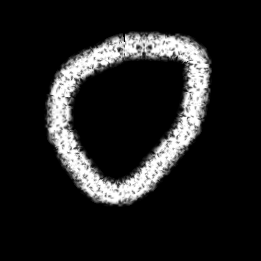

In [24]:
from PIL import Image
im = Image.open("digits/sample0.png")
im

此时如果直接将其转为 Numpy 数组会得到三个通道：

In [66]:
im_arr = np.array(im)
print(im_arr.shape)

(261, 261, 3)


因此，我们先强制转换为灰度图片（单通道），再缩放至模型的图片大小 28 x 28：

In [25]:
im = im.convert("L")
im.thumbnail((28, 28))
im_arr = np.array(im)
print(im_arr.shape)
im

(28, 28)


为了传递给模型对象，还需要先将数值归一化到 [0,1] 区间，转换为 PyTorch 的 Tensor 类型，并增加一个批次和一个通道的维度：

In [26]:
test0 = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
print(test0.shape)

torch.Size([1, 1, 28, 28])


最后对图片标签进行预测：

In [28]:
pred0 = model(test0)
print(np.round(pred0.detach().cpu().numpy(), 3))
print("预测标签：", torch.argmax(pred0).item())

[[0.116 0.    0.046 0.    0.    0.    0.    0.    0.    0.837]]
预测标签： 9


预测结果是否符合真实情形？请对你自己绘制出的10张图片进行类似的预测操作，并评价其效果。

在大部分测试样本上模型预测表现较好，但对于一些样本，此模型不能很好地区分0，4与9这三个数字

In [33]:
def pred_image(im, model):
    im_arr = np.array(im)
    im = im.convert("L")
    im.thumbnail((28, 28))
    im_arr = np.array(im)
    test = torch.tensor(im_arr / 255.0, dtype=torch.float32).view(1, 1, 28, 28)
    pred = model(test)
    return torch.argmax(pred).item(), np.round(pred.detach().cpu().numpy(), 3)

In [38]:
im = Image.open("digits/sample1.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0.004 0.987 0.    0.    0.004 0.    0.005 0.    0.    0.   ]]
预测标签： 1


In [37]:
im = Image.open("digits/sample2.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
预测标签： 2


In [39]:
im = Image.open("digits/sample3.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
预测标签： 3


In [42]:
im = Image.open("digits/sample4.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
预测标签： 4


In [35]:
im = Image.open("digits/sample5.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
预测标签： 5


In [43]:
im = Image.open("digits/sample6.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
预测标签： 6


In [44]:
im = Image.open("digits/sample7.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0.   0.05 0.09 0.   0.   0.   0.   0.86 0.   0.  ]]
预测标签： 7


In [36]:
im = Image.open("digits/sample8.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
预测标签： 8


In [46]:
im = Image.open("digits/sample9.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0.    0.001 0.    0.    0.71  0.    0.    0.276 0.    0.012]]
预测标签： 4


In [47]:
im = Image.open("digits/0.png")
pred, prob = pred_image(im, model)
print("分布概率：", prob)
print("预测标签：", pred)

分布概率： [[0.99 0.   0.01 0.   0.   0.   0.   0.   0.   0.  ]]
预测标签： 0


### 第2题

1. 目标：通过对英文名数据进行训练，构建一个 RNN 模型，实现英文名的自动生成。

2. 主要步骤：获取和整理数据，对字符串进行 one-hot 编码，创建模型结构，定义损失函数，编写训练循环，最后生成人名字符串。

3. 获取和整理数据。数据文件已存为 `data/names.txt`，先将其读取为字符串列表：

In [2]:
import io
lines = io.open("data/names.txt").read().strip().split('\n')
print(len(lines))
print(lines[0:5])

3668
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


可以看出，共读取了3668个名字。为了简单起见，我们将所有的大写字母转换为小写。

In [3]:
names = [s.lower() for s in lines]
print(names[0:10])

['abbas', 'abbey', 'abbott', 'abdi', 'abel', 'abraham', 'abrahams', 'abrams', 'ackary', 'ackroyd']


接下来我们需要构建一个字符的字典。对于英文名来说很简单，即26个字母。我们可以通过下面的代码直接得到。

In [4]:
import string
char_dict = string.ascii_lowercase
char_dict

'abcdefghijklmnopqrstuvwxyz'

4. 下面准备好 one-hot 编码所需的函数。编写函数 `char2index(char)`，将一个字母转换为其所在字典的位置。例如 `char2index("a")` 要返回0，`char2index("z")` 要返回25，等等。提示：使用字符串的 `.find()` 函数。

In [5]:
def char2index(char):
    if char in char_dict:
        return char_dict.find(char)
    else:
        return 26

print(char2index("z") == 25)

True


编写 `char2tensor(char)` 函数，将一个字母转换为 one-hot 向量，即该向量中第 i 个元素为1，其余为0，其中 i 表示该字母在字典中的位置。

**注意，该向量的长度应为27，因为我们要预留终止符，用 `[0.0, 0.0, ..., 1.0]` 表示**。

`char2tensor("a")` 应返回 `torch.tensor([1.0, 0.0, ...])`，`char2tensor("z")` 应返回 `torch.tensor([0.0, ..., 1.0, 0.0])`。

In [6]:
c = torch.zeros(27)

In [7]:
torch.tensor(1)

tensor(1)

In [8]:
def char2tensor(char):
    coding = torch.zeros(27)
    coding[char2index(char)] = torch.tensor(1.0)
    return coding

print(char2tensor("a"))
print(char2tensor("z"))
print(char2tensor("z").shape[0] == 27)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.])
True


5. 构建模型。我们使用最简单的 RNN 结构，即隐藏单元是输入和上一期隐藏单元的线性变换加上 Tanh 激活函数，输出单元是隐藏单元的线性变换加上 Softmax 激活函数。输出的结果代表下一个字符的概率分布。

In [9]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size+hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, 27)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.i2h(combined))
        output = torch.nn.functional.softmax(self.h2o(hidden), dim=1)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

我们做一个简单的测试。请在下面的代码中加入适当的语句，使得每次运行的结果不变。根据其输出结果，请问当前模型预测字符a的下一个字符是什么？为什么？

In [10]:
rnn = RNN(input_size=27, hidden_size=10)
input = char2tensor("a")
hidden = rnn.init_hidden()
output, hidden = rnn(input.view(1, 27), hidden)
print(output)

tensor([[0.0290, 0.0327, 0.0320, 0.0354, 0.0432, 0.0395, 0.0417, 0.0371, 0.0409,
         0.0275, 0.0328, 0.0359, 0.0373, 0.0391, 0.0339, 0.0366, 0.0430, 0.0364,
         0.0472, 0.0435, 0.0376, 0.0327, 0.0418, 0.0370, 0.0279, 0.0426, 0.0357]],
       grad_fn=<SoftmaxBackward>)


6. 接下来我们定义好损失函数。与第1题中类似，预测值是一个概率分布，而真实的标签是0到26中的一个整数，代表真实的下一个字符在字典中的位置。假设当前处理的名字为"abel"，那么字符a的输出结果对应的标签是什么？请完成下面的代码。

In [11]:
target = char2index('b')

lossfn = torch.nn.NLLLoss()
loss = lossfn(torch.log(output), torch.tensor([target]))
print(loss)

tensor(3.4199, grad_fn=<NllLossBackward>)


7. 明确单个字符的损失函数的计算方法后，请在下面计算出"abel"这个观测整体的损失函数值。

In [12]:
name = 'abel'
rnn = RNN(input_size=27, hidden_size=10)
hidden = rnn.init_hidden()
lossfn = torch.nn.NLLLoss()
loss = 0

for i in range(len(name)):
    input = char2tensor(name[i])
    output, hidden = rnn(input.view(1,27), hidden)

    if i == len(name) - 1:
        target = 26
    else:
        target = char2index(name[i + 1])

    loss = loss + lossfn(torch.log(output), torch.tensor([target]))

loss = loss / len(name)
print(loss)

tensor(3.2381, grad_fn=<DivBackward0>)


8. 将上述过程在数据上进行反复迭代，训练模型。

In [21]:
np.random.seed(123)
torch.random.manual_seed(123)

n = len(names)
n_hidden = 16
n_input = 27
nepoch = 50

rnn = RNN(n_input, n_hidden)
opt = torch.optim.Adam(rnn.parameters(), lr=0.0001)
train_ind = np.arange(n)
losses = []

lossfn = torch.nn.NLLLoss()

# Loop over epochs
for k in range(nepoch):
    # Shuffle the data
    np.random.shuffle(train_ind)
    # Loop over observations. Each observation is a name
    for i in range(n):
        name = names[train_ind[i]]
        nchar = len(name)
        # Loop over the characters in the name
        # Each input character has a target, which is the index of the next character in the dictionary
        # For the last character in the name, the target is the end-of-sequence symbol, which has index 26
        loss = 0.0
        hidden = rnn.init_hidden()
        for j in range(nchar):
            input = char2tensor(name[j])
            output, hidden = rnn(input.view(1, n_input), hidden)

            if j == nchar - 1:
                target = 26
            else:
                target = char2index(name[j + 1])

            loss = loss + lossfn(torch.log(output), torch.tensor([target]))
    
        loss = loss / nchar

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"epoch {k}, obs {i}, loss = {loss.item()}")

epoch 0, obs 0, loss = 3.3991856575012207
epoch 0, obs 1000, loss = 2.918344020843506
epoch 0, obs 2000, loss = 2.6398532390594482
epoch 0, obs 3000, loss = 3.1096529960632324
epoch 1, obs 0, loss = 2.776276111602783
epoch 1, obs 1000, loss = 2.5617995262145996
epoch 1, obs 2000, loss = 2.415987014770508
epoch 1, obs 3000, loss = 2.4527029991149902
epoch 2, obs 0, loss = 2.5975751876831055
epoch 2, obs 1000, loss = 2.585355520248413
epoch 2, obs 2000, loss = 2.5821340084075928
epoch 2, obs 3000, loss = 2.7673685550689697
epoch 3, obs 0, loss = 2.584155559539795
epoch 3, obs 1000, loss = 2.1915831565856934
epoch 3, obs 2000, loss = 2.4389891624450684
epoch 3, obs 3000, loss = 2.0150928497314453
epoch 4, obs 0, loss = 2.4576306343078613
epoch 4, obs 1000, loss = 2.9122250080108643
epoch 4, obs 2000, loss = 2.5470449924468994
epoch 4, obs 3000, loss = 2.1251466274261475
epoch 5, obs 0, loss = 2.283302068710327
epoch 5, obs 1000, loss = 2.564319133758545
epoch 5, obs 2000, loss = 2.1136810

epoch 46, obs 0, loss = 2.150540590286255
epoch 46, obs 1000, loss = 2.5037455558776855
epoch 46, obs 2000, loss = 1.8907172679901123
epoch 46, obs 3000, loss = 1.9620060920715332
epoch 47, obs 0, loss = 1.9173694849014282
epoch 47, obs 1000, loss = 1.7572441101074219
epoch 47, obs 2000, loss = 1.3365674018859863
epoch 47, obs 3000, loss = 2.493136405944824
epoch 48, obs 0, loss = 2.7950522899627686
epoch 48, obs 1000, loss = 1.458345651626587
epoch 48, obs 2000, loss = 2.025412082672119
epoch 48, obs 3000, loss = 2.5827722549438477
epoch 49, obs 0, loss = 2.926356554031372
epoch 49, obs 1000, loss = 2.778064727783203
epoch 49, obs 2000, loss = 1.9001984596252441
epoch 49, obs 3000, loss = 2.080321788787842


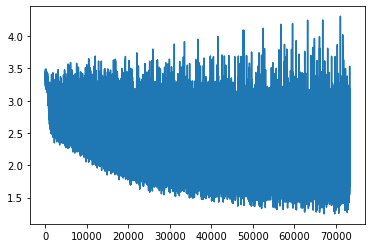

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses)

9. 编写一个函数 `random_first_letter()`，它随机返回字典中的一个字符，我们将利用它来随机生成第一个字符。

In [15]:
def random_first_letter():
    idx = np.random.randint(0, 25)
    return char_dict[idx]

print(random_first_letter())
print(random_first_letter())
print(random_first_letter())

v
c
a


请简要说明如下的代码的含义（可以在代码中加入注释），然后利用它随机生成10个名字。评价生成的结果，并简要说明可以如何改进模型的效果？

In [16]:
def random_name(max_len=20):
    # 将模型从训练调整到预测模式，去掉训练中的dropout或batch normlization层等
    rnn.eval()
    # 随机产生名字的第一个字母，并将其转化成tensor形式，作为RNN的第一个输入
    first_letter = random_first_letter()
    char_ind = [char2index(first_letter)]
    input = char2tensor(first_letter)
    # 初始化隐藏状态
    hidden = rnn.init_hidden()
    # 将第一个字母与初始隐藏状态带入RNN模型中，不断产生下一个字母，直至达到名字最大长度或生成的下一个字母为终止符
    for i in range(max_len - 1):
        output, hidden = rnn(input.view(1, n_input), hidden)
        # 找到生成的下一个字母对应的tensor中的下标为1的位置
        ind = torch.argmax(output).item()
        if ind == 26:
            break
        char_ind.append(ind)
        # 将输入更新为当前产生的字母对应的tensor
        input.zero_()
        input[ind] = 1.0
    return "".join([char_dict[i] for i in char_ind])

生成的单词比较符合英语单词的一般形式，但大多不能作为名字，而且学习到的字母组合方式比较单一。模型训练时的损失值波动性也较大，很难降低。可能需要尝试更加复杂一点的模型结构，并且增加训练数据数量。

In [22]:
for _ in range(10):
    print(random_name(max_len=10))

darder
vinger
burn
arder
sone
order
harder
corder
order
qurder


### 第3题

利用卷积函数实现任意大整数的乘法。给定两个整数，如 183612 和 23333，用两个列表表达它们的序列：

In [49]:
n1 = [1, 8, 3, 6, 1, 2]
n2 = [2, 3, 3, 3, 3]

请编写一个函数 `integer_mult(n1, n2)`，返回 `n1 * n2` 对应的整数序列。注意不要直接调用乘法表达式（设想有两个非常大的整数，直接相乘可能会导致数值溢出）。

In [65]:
def integer_mult(n1, n2):
    poly_multi_result = np.convolve(n1, n2)
    to_next = 0
    params = []
    for j in poly_multi_result[::-1]:
        params.append((j + to_next) % 10)
        to_next = (j + to_next) // 10
    while to_next:
        params.append(to_next % 10)
        to_next = to_next // 10  
    return params[::-1]

res = integer_mult(n1, n2)
print(res)
print(res == [4, 2, 8, 4, 2, 1, 8, 7, 9, 6])

[4, 2, 8, 4, 2, 1, 8, 7, 9, 6]
True


思路：

1. 先实现多项式的乘法。例如，给定 $p(x)=1+2x+x^4$ 和 $q(x)=x+3x^2+5x^3$，计算 $r(x)=p(x)q(x)$。我们将 $p(x)$ 编码为 `p = [1, 2, 0, 0, 1]`，$q(x)$ 编码为 `q = [0, 1, 3, 5]`，请编写函数 `poly_mult(p, q)`，使得 `poly_mult(p, q) == [0, 1, 5, 11, 10, 1, 3, 5]`。

In [52]:
p = [1, 2, 0, 0, 1]
q = [0, 1, 3, 5]

def poly_mult(p, q):
    return np.convolve(p, q)

print(poly_mult(p, q) == [0, 1, 5, 11, 10,  1, 3, 5])

[ True  True  True  True  True  True  True  True]


2. 对于任意的一个整数，将其看成是某个多项式在 $x=10$ 处的取值，如 $123 = p_1(10)$，$p_1(x)=3+2x+x^2$，$5310 = p_2(10)$，$p_2(x)=x+3x^2+5x^3$，注意需要适当将序列反序。因此，要计算 $123\times 5310$，相当于计算 $r(10)$ 的值，但为了避免直接进行乘法运算（防止溢出），可以先计算 $r(x)$ 的表达式（等价于其系数向量），然后建立起 $r(x)$ 的系数与 $r(10)$ 之间的联系（见如下第3点）。

3. 如果一个多项式 $r(x)$ 所有的系数都是0到9之间的整数，那么 $r(x)$ 和 $r(10)$ 的关系非常直接，比如若 $r(x)=1+2x+5x^2+3x^3$，则 $r(10)=3521$。但如果有系数超过10，就需要考虑进位的影响，比如 $r(x)=1+11x+2x^2$，$r(10)=311$。此时可以从 $r(x)$ 的第一项开始逐项进位，构造一个新的多项式 $r'(x)=1+x+3x^2$，满足 $r'(10)=r(10)$，且 $r'(x)$ 所有的系数都不超过10。 

4. 综合利用以上信息，完成本题的算法编写。并测试 23742389754298365 * 809723950 的结果。

In [91]:
def integer_mult(n1, n2):
    poly_multi_result = np.convolve(n1, n2)
    to_next = 0
    params = []
    for j in poly_multi_result[::-1]:
        params.append((j + to_next) % 10)
        to_next = (j + to_next) // 10
    while to_next:
        params.append(to_next % 10)
        to_next = to_next // 10  
    return params[::-1]

def big_number_multi(params):
    result = 0
    for i, j in enumerate(params[::-1]):
        result = result + (10**i)*j
    return result

将两个数字表示成列表表达形式

In [85]:
n1 = [2,3,7,4,2,3,8,9,7,5,4,2,9,8,3,6,5]
n2 = [8,0,9,7,2,3,9,5,0]

计算乘积多项式系数

In [87]:
poly_params = integer_mult(n1, n2)
print(poly_params)

[1, 9, 2, 2, 4, 7, 8, 1, 6, 1, 4, 2, 9, 0, 0, 0, 1, 5, 8, 6, 3, 4, 1, 7, 5, 0]


将$x=10$带入多项式中进行计算，得到乘积

In [92]:
big_number_multi(poly_params)

1.9224781614290002e+25